<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/part_6_customise_state_human_in_the_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Quick Start***
In this comprehensive quick start, we will build a support chatbot in LangGraph that can:

Answer common questions by searching the web
Maintain conversation state across calls
Route complex queries to a human for review
Use custom state to control its behavior
Rewind and explore alternative conversation paths
We'll start with a basic chatbot and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way.

Setup
First, install the required packages:

In [249]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai tavily-python langchain_community

In [250]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

gemini_api_key = userdata.get('my_stenographer_key')
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

In [251]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)
# tool = TavilySearchResults(max_results=2)
# tools = [tool]

In [252]:
from langchain_community.tools.tavily_search import TavilySearchResults # Import the necessary class

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [253]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END  # Ensure END is imported
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import AIMessage, ToolMessage
from IPython.display import Image, display

# Initialize MemorySaver
memory = MemorySaver()

# Define the State class with messages and ask_human flag
class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool  # This flag is new


In [254]:
# Define the RequestAssistance model using Pydantic
class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions."""
    request: str

In [255]:
# Initialize tools
tool = TavilySearchResults(max_results=2)
tools = [tool]

# Bind the LLM to tools and the RequestAssistance model
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])

In [256]:
response = llm_with_tools.invoke("i need some tips about loss weight")
response.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (c2dbf9ae-db4e-4bb3-b0b1-a01e60cc984a)
 Call ID: c2dbf9ae-db4e-4bb3-b0b1-a01e60cc984a
  Args:
    query: tips for weight loss


In [257]:


# Define the chatbot function
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

# Initialize the StateGraph
graph_builder = StateGraph(State)
# is node ma phla llm ko call ki msg pas kro or human ki need ni ha i mean false or ager
# human ki need ha true kro or wo query human ko pass krdo phr ek statgraph bnao

In [258]:
# Add nodes to the graph
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


In [259]:
# Define the create_response function
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,  # Human ka response yahan content mein set hota hai
        tool_call_id=ai_message.tool_calls[0]["id"],  # AI message se related tool call ID set hoti hai
    )

    # this is helper function
    # get resonse by human and return and convert in tool msg

# Define the human_node function
def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Add placeholder message if no response from human
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        "messages": new_messages,
        "ask_human": False,  # Reset ask_human flag
    }
# Human node ka purpose hai human ke response ka wait karna. Agar human reply nahi karta,
#  toh chatbot "No response from human." message khud hi add kar deta hai aur ask_human flag
# ko False set karta hai, jo batata hai ke ab human ki zaroorat nahi hai aur chatbot aage
# continue kar sakta hai.
# Add the human node to the graph
graph_builder.add_node("human", human_node)

In [260]:
# Define the select_next_node function
def select_next_node(state: State):
  # ager true ha to human ko query bhjo
    if state["ask_human"]:
        return "human"
    return tools_condition(state)
    # werna tool  k pas bhjo

# Add conditional edges to the graph
graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "END": END}
)
# chatbot na select krna ha k human k pas tool k pas ya phr end krna ha query ko

In [261]:
# Add other necessary edges
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Compile the graph without end_node (removed based on error)
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"]
)


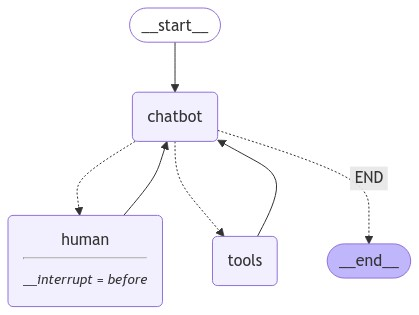

In [262]:
# Display the graph (optional, requires additional dependencies)
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [263]:
# Sample user input
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

In [273]:
# Stream the events from the graph
events = graph.stream(
    # graph.stream function ke through user_input ko graph mein stream kiya ja raha hai.
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
# Yeh dictionary format mein input ko set karta hai, jisme user ka input message contain hota hai.
# stream_mode="values" – Iska matlab hai ke yeh stream values ko process karte hue ek series of events generate karega.

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()
# Ye code loop karta hai har event ke through jo chatbot ne generate kiya hai. Agar event mein
# "messages" key ho, toh wo latest message ko readable format mein display karta hai, taake user
# ko chatbot ka response asaani se samajh aaye.

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (d666ab61-4d73-4bd1-85c2-24d62940d67c)
 Call ID: d666ab61-4d73-4bd1-85c2-24d62940d67c
  Args:
    request: I need help building an AI agent. Could you connect me with an expert?


In [265]:
snapshot=graph.get_state(config)
snapshot.next

('human',)

In [267]:
# Handling human response and updating state
ai_message = graph.get_state(config).values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)


In [268]:
# Aik snapshot ya response ko `ai_message` mein store karna

# Phir `ai_message` ko create_response function mein use karein
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9cde7-db22-6fdb-8002-bd3a8d42d207'}}

In [269]:
print(graph.get_state(config).values["messages"])

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='a1d1489e-81bc-46da-b3ba-b4395a70fe08'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'RequestAssistance', 'arguments': '{"request": "I need help building an AI agent. Can you connect me with an expert?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-380ac1df-b300-4594-a825-a2a6dd3f9006-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'reque

In [272]:
for m in graph.get_state(config).values["messages"]:
  m.pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (c166532b-c1dd-442c-9323-f8097c1a1470)
 Call ID: c166532b-c1dd-442c-9323-f8097c1a1470
  Args:
    request: I need help building an AI agent. Can you connect me with an expert?
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
